# AML Coursework assessment

## Data Exploration

### Wisconsin Diagnostic Breast Cancer Dataset

The Wisconsin Diagnostic Breast Cancer dataset describes the measurements on cells in suspicious lumps in a women's breast. This dataset, obtained from the University of Wisconsin Hospitals, includes 30 feature variables and 1 target variable. 

The features, or input attributes, are numeric, and a binary target variable: M for Malignant and B for benign.

Each cell-nucleus include 10 actual features:

- Radius (mean of distances from center to points on the perimeter)
- Texture (standard deviation of gray-scale values)
- Perimeter
- Area
- Smoothness (local variation in radius lengths)
- Compactness (perimeter^2 / area - 1.0)
- Concavity (severity of concave portions of the contour)
- Concave points (number of concave portions of the contour)
- Symmetry 
- Fractal dimension ("coastline approximation" - 1)

Now, we will load the dataset so we can check the data in detail. To do so, we'll install the required libraries and packages.

In [1]:
!pip3 install matplotlib pandas numpy seaborn scikit-learn

In [2]:
!pip3 install -U ucimlrepo

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

data_combined = pd.concat([X, y], axis=1)
  
# metadata 
#print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
#print(breast_cancer_wisconsin_diagnostic.variables)



### Checking the data

We'll retrieve a data preview of the data so we can have a first look at it.

In [4]:
# Print the first few rows of the data
print("\nFirst few rows of Features and Target combined")
print(data_combined.head())


First few rows of Features and Target combined
   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  texture3  \
0      0.3001          0.14710     0.2419             0.07871  ...     17.33   
1      0.0869          0.07017     0.1812             0.05667  ...     23.41   
2      0.1974          0.12790     0.2069             0.05999  ...     25.53   
3      0.2414          0.10520     0.2597             0.09744  ...     26.50   
4      0.1980          0.10430     0.1809             0.05883  ...     16.67   

   perimeter3   area3  smoothness3  compactn

### The dimensionality of the dataset

We can see that we're able to access the repository from UCIML and the data is loaded. Now we need to understand the dimensionality of the dataset in terms of number of rows, columns (features and target variable).

In [5]:
# Print the shape of the data

print("Shape of X (features):", X.shape)
print("Shape of y (targets):", y.shape)

Shape of X (features): (569, 30)
Shape of y (targets): (569, 1)


### Statistical Summary

Let's retrieve the statistical properties of each attribute in order to get some insights.

In [6]:
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3)

descriptionDataCombined = data_combined.describe()

print(descriptionDataCombined)

       radius1  texture1  perimeter1     area1  smoothness1  compactness1  concavity1  \
count  569.000   569.000     569.000   569.000      569.000       569.000     569.000   
mean    14.127    19.290      91.969   654.889        0.096         0.104       0.089   
std      3.524     4.301      24.299   351.914        0.014         0.053       0.080   
min      6.981     9.710      43.790   143.500        0.053         0.019       0.000   
25%     11.700    16.170      75.170   420.300        0.086         0.065       0.030   
50%     13.370    18.840      86.240   551.100        0.096         0.093       0.062   
75%     15.780    21.800     104.100   782.700        0.105         0.130       0.131   
max     28.110    39.280     188.500  2501.000        0.163         0.345       0.427   

       concave_points1  symmetry1  fractal_dimension1  ...  radius3  texture3  perimeter3  \
count          569.000    569.000             569.000  ...  569.000   569.000     569.000   
mean        

### Class Distribution

As this is a classification problem, we need to analyse the data in order to check how many observations do we have for each class. If they are highly imbalanced, then we'll need to take further actions in the data pre-processing.

In [7]:
class_counts = data_combined.groupby('Diagnosis').size()
print(class_counts)

total = class_counts.sum()
proportion_B = class_counts['B'] / total
proportion_M = class_counts['M'] / total

print(f"\nProportion of class B: {proportion_B:.2f}")
print(f"Proportion of class M: {proportion_M:.2f}")

Diagnosis
B    357
M    212
dtype: int64

Proportion of class B: 0.63
Proportion of class M: 0.37


### Features Correlation 

By calculating the correlation between the different variables we'll be able to analyse if they are tightly coupled (highly correlated). This is important as it can affect the performance of the machine learning algorithms.

Let's calculate the Pearson's Correlation Coefficient, assuming that we have a normal distribution in the attributes. Before that, we need to convert the target variable to a numeric one.

In [8]:
# Convert the Diagnosis column from string to numerical values.
data_combined['Diagnosis'] = data_combined['Diagnosis'].map({'M': 1, 'B': 0})

# Calculate the Pearson's Correlation Coefficient
correlations = data_combined.corr(method='pearson')
print(correlations)

                    radius1  texture1  perimeter1  area1  smoothness1  compactness1  concavity1  \
radius1               1.000     0.324       0.998  0.987        0.171         0.506       0.677   
texture1              0.324     1.000       0.330  0.321       -0.023         0.237       0.302   
perimeter1            0.998     0.330       1.000  0.987        0.207         0.557       0.716   
area1                 0.987     0.321       0.987  1.000        0.177         0.499       0.686   
smoothness1           0.171    -0.023       0.207  0.177        1.000         0.659       0.522   
compactness1          0.506     0.237       0.557  0.499        0.659         1.000       0.883   
concavity1            0.677     0.302       0.716  0.686        0.522         0.883       1.000   
concave_points1       0.823     0.293       0.851  0.823        0.554         0.831       0.921   
symmetry1             0.148     0.071       0.183  0.151        0.558         0.603       0.501   
fractal_di

As the table size is big, let's retrieve those variables that are highly correlated (> 0.75) by sorting and printing them.

In [9]:
# Unstack the correlation matrix
correlation_pairs = correlations.unstack()

# Sort the correlation pairs
sorted_pairs = correlation_pairs.sort_values(kind="quicksort", ascending=False)

# Retrieve high correlations and exclude self-correlations, as they aren't relevant.
high_correlations = sorted_pairs[(sorted_pairs != 1.0) & (sorted_pairs.abs() > 0.75)]

print(high_correlations)

perimeter1       radius1            0.998
radius1          perimeter1         0.998
radius3          perimeter3         0.994
perimeter3       radius3            0.994
area1            radius1            0.987
                                    ...  
compactness3     concavity1         0.755
concavity3       concave_points1    0.752
concave_points1  concavity3         0.752
radius2          area3              0.752
area3            radius2            0.752
Length: 114, dtype: float64


Let's plot a correlation matrix to achieve a better understanding of the data correlation

Datasource: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

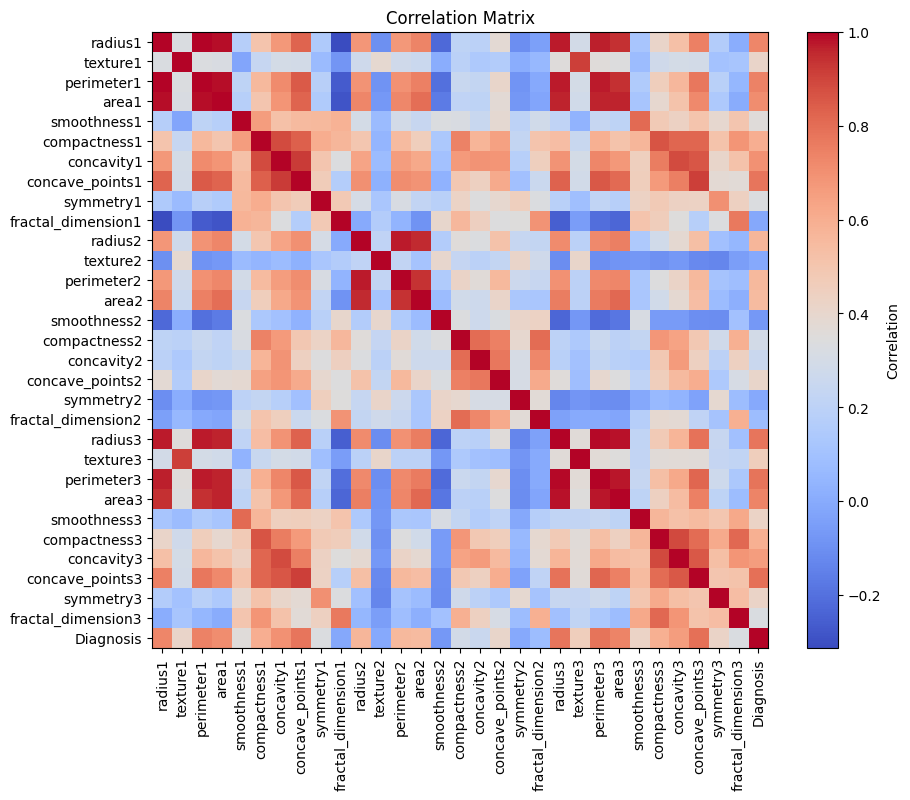

In [10]:
# Plotting the Correlation Matrix

plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations.index)), correlations.index)
plt.show()

We can see that the highly correlated variables are the radius and perimeter. This makes sense due to its mathematical relationship, as the radius is directly proportional to the perimeter.

### Skew of Univariate Distributions

Now we'll check if there is any attribute with a skew, in order to consider it during our data preparation phase.

In [11]:
skew = data_combined.skew()

sorted_skew = skew.sort_values(ascending=False)

negative_skew = sorted_skew[sorted_skew < 0]
positive_skew = sorted_skew[sorted_skew > 0]
higher_skew = sorted_skew[sorted_skew > 1]

print("\nNegative Skew\n")
print(negative_skew)

print("\nPositive Skew\n")
print(positive_skew)

print("\nHigher Skew\n")
print(higher_skew)


Negative Skew

Series([], dtype: float64)

Positive Skew

area2                 5.447
concavity2            5.110
fractal_dimension2    3.924
perimeter2            3.444
radius2               3.089
smoothness2           2.314
symmetry2             2.195
compactness2          1.902
area3                 1.859
fractal_dimension3    1.663
texture2              1.646
area1                 1.646
compactness3          1.474
concave_points2       1.445
symmetry3             1.434
concavity1            1.401
fractal_dimension1    1.304
compactness1          1.190
concave_points1       1.171
concavity3            1.150
perimeter3            1.128
radius3               1.103
perimeter1            0.991
radius1               0.942
symmetry1             0.726
texture1              0.650
Diagnosis             0.528
texture3              0.498
concave_points3       0.493
smoothness1           0.456
smoothness3           0.415
dtype: float64

Higher Skew

area2                 5.447
concavity2      

The skew result shows there is no negative skew as all attribute values are positive. 
Additionally, we can see that some features have a higher skew than the rest of the features as they are greater than 3.
Now, we'll plot the histograms of each attribute in order to check the distribution of each of them.

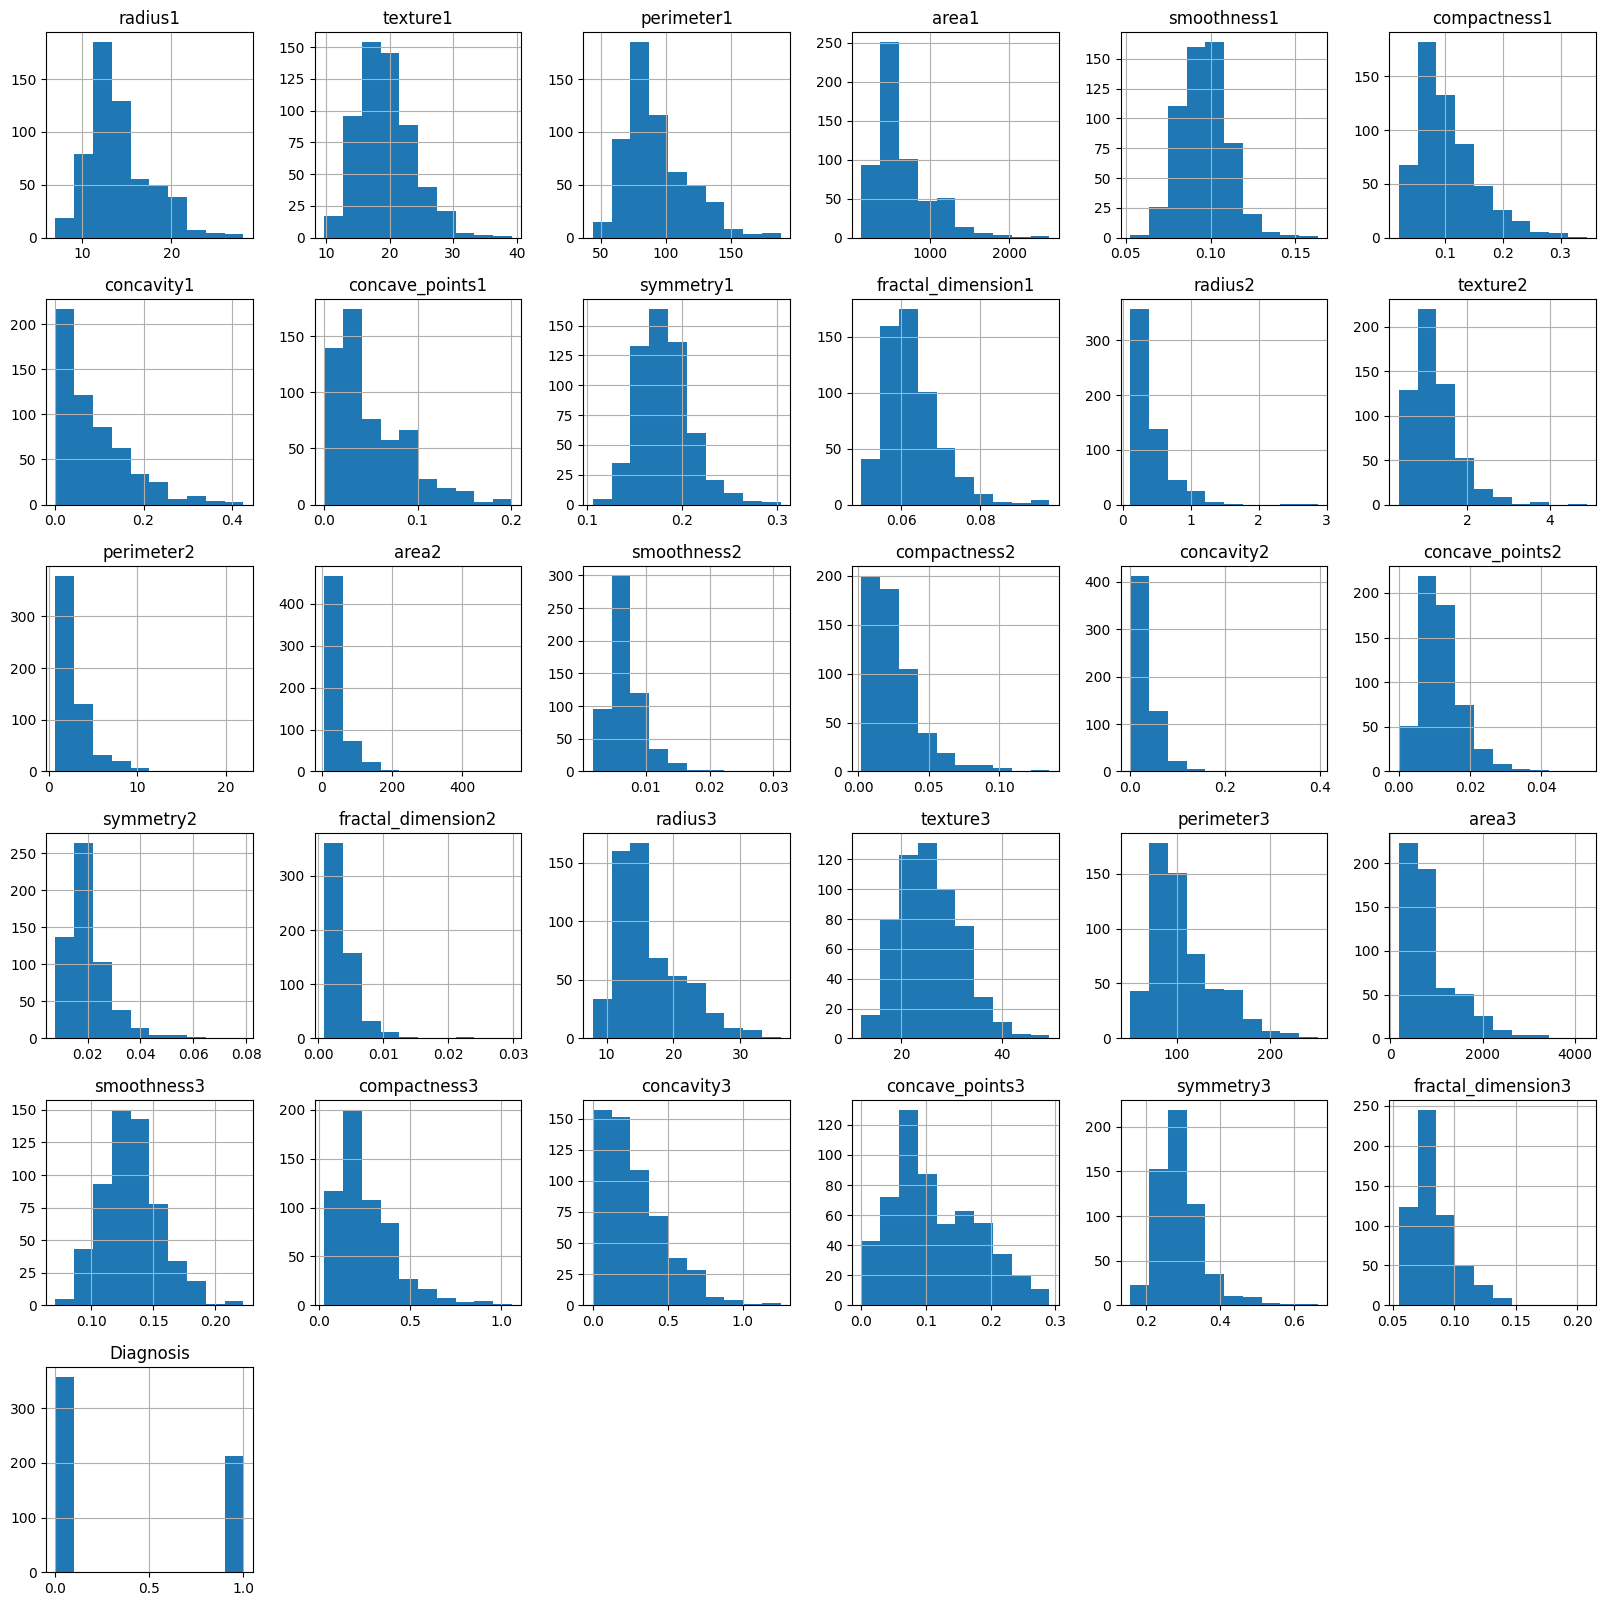

In [12]:
# Univariate Histograms
data_combined.hist(figsize=[20, 20])
plt.show()

## Data Transformation

We don't see the need of any major rescaling or transformation in the data. What is needed, is to transform the target column, as it isn't numeric.

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y.squeeze())

# Print the transformed target variable to check if we have transformed it correctly
print("Transformed Target Variables (First 10 elements):", y_numeric[:10])

Transformed Target Variables (First 10 elements): [1 1 1 1 1 1 1 1 1 1]


## Feature Selection

### Principal Component Analysis (PCA)

As a preprocessing step, and in order to exclude irrelevant or redundant features, we will carry out a dimensionality reduction using the PCA technique. 

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
fit = pca.fit(X)

# Get the explained variance ratios
explained_variance_ratios = fit.explained_variance_ratio_

# Transform the explained variance ratios into percentages
explained_variance_percentages = explained_variance_ratios * 100

# Print the explained variance percentages
for i, explained_variance_percentage in enumerate(explained_variance_percentages):
    print(f"Explained Variance for PC{i+1}: {explained_variance_percentage:.10f}%")

Explained Variance for PC1: 98.2044671511%
Explained Variance for PC2: 1.6176489864%
Explained Variance for PC3: 0.1557510745%
Explained Variance for PC4: 0.0120931964%
Explained Variance for PC5: 0.0088272454%
Explained Variance for PC6: 0.0006648840%
Explained Variance for PC7: 0.0004017137%
Explained Variance for PC8: 0.0000822017%
Explained Variance for PC9: 0.0000344135%
Explained Variance for PC10: 0.0000186019%


We see that the Principal Component 1 has a significantly higher variance than the rest so it makes sense to only keep it. Because of that, we will reduce the number of components to 2.

In [15]:
pca = PCA(n_components=2)
fit = pca.fit(X)

# Get the explained variance ratios
explained_variance_ratios = fit.explained_variance_ratio_

# Transform the explained variance ratios into percentages
explained_variance_percentages = explained_variance_ratios * 100

# Print the explained variance percentages
for i, explained_variance_percentage in enumerate(explained_variance_percentages):
    print(f"Explained Variance for PC{i+1}: {explained_variance_percentage:.10f}%")

Explained Variance for PC1: 98.2044671511%
Explained Variance for PC2: 1.6176489864%


Now that we have two PCs, we will fit them to the original data

In [16]:
X_pca = pca.fit_transform(X)

## Resampling

Since we already have the transformed dataset with the two selected components stored in the variable X_PCA, we will perform the resampling method K-Fold Cross-Validation to know how well the different models perform with data that haven´t been used to train them.

### Model Performance Estimation

We'll estimate the performance of 3 different machine learning algorithms using the K-Fold Cross-Validation:
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

num_folds = 10
seed = 7

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

model1 = LogisticRegression(solver = 'liblinear')
results = cross_val_score(model1, X, y_numeric, cv=kfold)
print("Logistc Regression Model Accuracy: %.3f%% (%.3f%%)" % (results.mean() * 100.0, results.std() * 100.0))

model2 = DecisionTreeClassifier()
results = cross_val_score(model2, X, y_numeric, cv=kfold)
print("Decision Tree Classifier Model Accuracy: %.3f%% (%.3f%%)" % (results.mean() * 100.0, results.std() * 100.0))

model3 = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=seed)
results = cross_val_score(model3, X, y_numeric, cv=kfold)
print("Random Forst Classifier Model Accuracy: %.3f%% (%.3f%%)" % (results.mean() * 100.0, results.std() * 100.0))



Logistc Regression Model Accuracy: 94.552% (2.536%)
Decision Tree Classifier Model Accuracy: 92.281% (3.438%)
Random Forst Classifier Model Accuracy: 96.485% (1.754%)
